<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/Stellate_N_cancer_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRN model for stellate cells in pancreas.

Para modelar correctamente la red de regulación genética, renormbraremos las variables del sistema para poder simplificar el proceso

| $TNF_a$ | $TGFb_1$ | $RAS$ | $P53$ | $PIP3$ | $ERK$ | Apoptosis | Proliferation |
|:-------:|:--------:|:-----:|:-----:|:------:|:-----:|:-----------:|:---------------:|
|  $X_1$  |   $X_2$  | $Y_1$ | $Y_2$ |  $Y_3$ | $Y_4$ |    $Z_1$    |      $Z_2$      |

\begin{align}
    \dot{x_1} &= x_1^{\infty} - x_1(t) \\
    \dot{x_2} &= x_2^{\infty} - x_2(t) \\
    \dot{y_1} &= \left(\alpha_1 x_1 + \beta_3^{-} y_3 + \beta_2 y_4\right) - \left(\beta_2 + \beta_3^{+}\right)y_1 \\
    \dot{y_2} &= \left(\beta_1y_1 + \frac{\delta_2k_2^{n_2}}{k_2^{n_2} + y_3^{n_2}} + \frac{\delta_4k_4^{n_4}}{k_4^{n_4} + y_2^{n_4}}\right) - \gamma_1 y_2 \\
    \dot{y_3} &=\left(\alpha_3x_2 + \beta_3^{+}y_1 + \frac{\delta_1k_1^{n_1}}{k_1^{n_1}+y_2^{n_1}}\right) - \beta_3^{-}y_3 \\
    \dot{y_4} &= \alpha_3 x_2 - \left(\beta_2 + \gamma_2\right)y_4 \\
    \dot{z_1} &= \gamma_1 y_2 - z_1\\
    \dot{z_2} &= \gamma_2 y_4 + \frac{\delta_3k_3^{n_3}}{k_3^{n_3} + y_4^{n_3}} - z_2 \\ 
    \dot{N} &= \frac{\mu_2}{\mu_2 + z_2^n} - \frac{\mu_1}{\mu_1 + z_1^n} 
\end{align}
---



In [74]:
import matplotlib.pyplot as plt
import numpy as np
import random 

In [75]:
def supr(e, n, s):
    return e/(1 + s**n)

In [76]:
def dS(S, i):
    # RY, RC, RZ, Y, C, Z = S
    Ry1, Ry2, Ry3, Ry4, Rc2, Rc3, Rc4, Rc5, Rz1, Rz2, Rz3, Rz4, y1, y2, y3, y4, c2, c3, c4, c5, z1, z2, z3, z4 = S
    # --------------------------------------------------------
    dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1) + supr(1, n[0], y3) + supr(1, n[0], y4) + supr(1, n[0], c3)) - Ry1
    dy1  = supr(1, n[1], Ry1) - y1

    dRy2 = e[1]*(supr(1, n[0], y1) + supr(1, -n[0], y2) + supr(1, -n[0], y3)) - Ry2
    dy2  = supr(1, n[1], Ry2) - y2;

    dRy3 = e[2]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1) + supr(1, -n[0], y2)) - Ry3
    dy3  = supr(1, n[1], Ry3) - y3;

    dRy4 = e[3]*(supr(1, n[0], X2[i]) + supr(1, n[0], y2)) - Ry4
    dy4  = supr(1, n[1], Ry4) - y4;
    # --------------------------------------------------------
    dRc2 = e[5]*(supr(2, -n[0], c2) + supr(2, -n[0], c3) + supr(1, n[0], c3) + supr(1, -n[0], c5)) - Rc2
    dc2  = supr(1, n[1], Rc2) - c2;

    dRc3 = e[6]*(supr(1, n[0], y1) + supr(1, -n[0], c2)) - Rc3
    dc3  = supr(1, n[1], Rc3) - c3;

    dRc4 = e[7]*(supr(1, n[0], y1) + supr(1, n[0], c3) + supr(2, -n[0], c2)) - Rc4
    dc4  = supr(1, n[1], Rc4) - c4;

    dRc5 = e[8]*(supr(1, n[0], X2[i]) + supr(1, n[0], c2)) - Rc5
    dc5  = supr(1, n[1], Rc5) - c5;
    # --------------------------------------------------------
    dRz1 = dRy2;
    dz1  = dy2;

    dRz2 = e[4]*(supr(1, -n[0], y2) + supr(1, n[0], y4)) - Rz2
    dz2  = supr(1, n[1], Rz2) - z2;

    dRz3 = e[9]*(supr(2, -n[0], c3) + supr(1, n[0], c2) + supr(1, -n[0], c4)) - Rz3
    dz3  = supr(1, n[1], Rz3) - z3;

    dRz4 = e[10]*(supr(1, n[0], y1) + supr(1, n[0], c3) + supr(1, -n[0], c5)) - Rz4
    dz4  = supr(1, n[1], Rz4) - z4;
    # --------------------------------------------------------
    dS = dRy1, dRy2, dRy3, dRy4, dRc2, dRc3, dRc4, dRc5, dRz1, dRz2, dRz3, dRz4, dy1, dy2, dy3, dy4, dc2, dc3, dc4, dc5, dz1, dz2, dz3, dz4

    return np.array(dS)

In [77]:
def RK_solver(S0, t):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.empty([len(t)+1, dims])
    
    for d in range(dims):   
        S[0, d] = S0[d]

    dt = t[1] - t[0]; 
    for i in range(len(t)):
        K[0] = dt * dS(S[i]         , i) 
        K[1] = dt * dS(S[i] + K[0]/2, i)
        K[2] = dt * dS(S[i] + K[1]/2, i)
        K[3] = dt * dS(S[i] + K[2]  , i)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    # S = S[0:-1,:]
    return S

In [78]:
# parámetros
n = [-4, -20] 
e = [1/0.25, 1/2.25, 1/2.25, 1/0.25, 1/1.25, 1/4.25, 1.25, 2.25, 0.25, 2.75, 1.75]

start=0; step=0.05; num=1000
t = np.arange(0,num)*step+start

<ipython-input-75-c9dcc9093113>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return e/(1 + s**n)


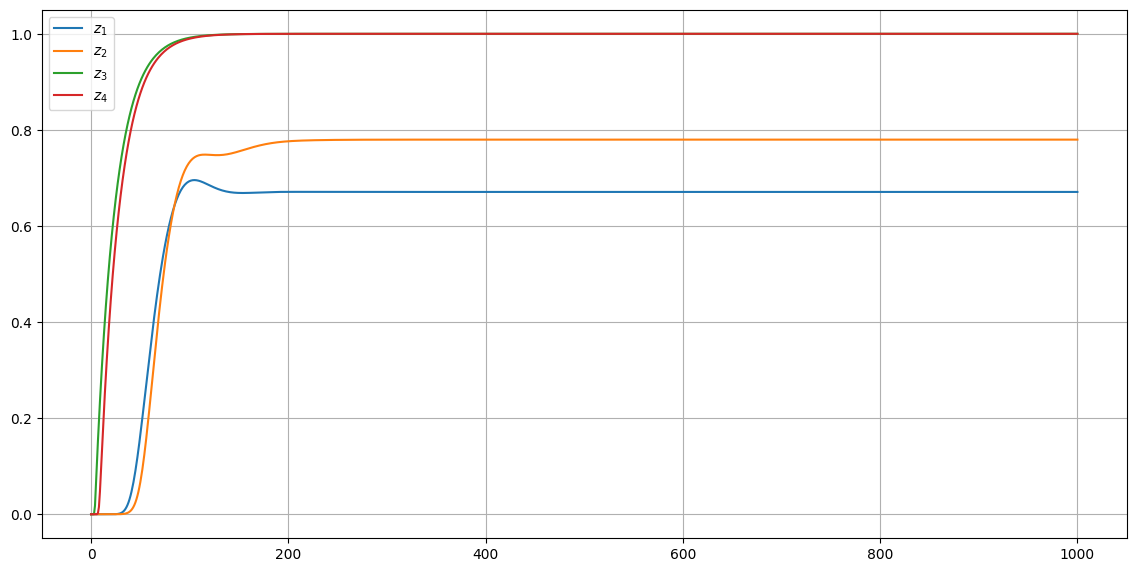

In [83]:
S0 = np.concatenate([np.zeros(4*3), np.array([1, 0, 1, 1]), np.array([1, 1, 1, 0]), np.zeros(4)])      # R, Y, C, Z
# omega = 1/5.715; X1, X2 = np.cos(t*omega)**2, np.sin(t*omega)**2            # omega_max = 7.715
X1, X2 = np.ones(num + 20), np.ones(num)       
labels = ["$z_1$", "$z_2$", "$z_3$", "$z_4$"]

Pip = RK_solver(S0, t)
plt.figure(figsize=(14,7), dpi=100)
for i in range(len(Pip[0])-20):
    plt.plot(Pip[:,i+20], label=labels[i])
# for i in range(len(Pip[0])-8):             plt.plot(Pip[:,i+8], label=labels[i+3])
# plt.plot(X1)
plt.legend(); plt.grid(); plt.show()

In [82]:
Pip[-1,:]

array([7.99994885e+00, 1.03624800e+00, 8.14025804e-01, 2.67376777e+00,
       1.01406696e+00, 1.75610733e+00, 6.32195746e+00, 1.48778534e-01,
       1.03624800e+00, 1.06524644e+00, 4.38663457e+00, 3.49997751e+00,
       1.00000000e+00, 6.70871613e-01, 1.60595091e-02, 9.99999997e-01,
       5.69393910e-01, 9.99987148e-01, 1.00000000e+00, 2.82361917e-17,
       6.70871613e-01, 7.79735129e-01, 1.00000000e+00, 1.00000000e+00])